In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import sys
sys.path.append('../')

import time
import numpy as np
from math import sqrt
from utils import paras
import sys
import os
import pickle
import argparse
import numpy as np
from env import *
from algo import *
from utils import Logger
from bandit_algo import *
import matplotlib.pyplot as plt

In [3]:
eps = 1e-5

In [4]:
class SCO_batch_env:
    def __init__(self, params):
        paras(self, params)
        self.random_seed = params['env']['random_seed']
        self.x_std = params['env']['x_std']
        self.y_std = params['env']['y_std']
        self.algo = params['algo']['type']
        self.p = params['env']['p']
        if np.isinf(self.p):
            self.q = 1
        else:
            self.q = self.p / (self.p - 1)
        self.logger = params['logger']
    
    def run(self):
        # init theta
        theta = np.zeros(shape = self.size_SCO)
        theta[:self.s] = 1
        theta /= np.linalg.norm(theta.flatten(), self.p)
        
        X = np.random.normal(0, self.x_std, size = (self.T, self.d))
        X = np.array([x/np.linalg.norm(x, self.q) for x in X])
        y = X.dot(theta) + np.random.normal(0, self.y_std, size = (self.T, 1))
        S = np.hstack((X,y))
        self.theta_hat = self.algo.train(S, theta, self.logger)


In [5]:
class Algo(object):
    def __init__(self, params):
        paras(self, params)

    def update(self, theta0, theta1, x, y):
        pass

    def train(self,theta):
        self.start_time = time.time()
        X = np.random.normal(0, self.x_std, size=(self.test_size, self.d))
        self.X = np.array([x/np.linalg.norm(x, self.q) for x in X])
        self.y = self.X.dot(theta) + np.random.normal(0, self.y_std, size=(self.test_size, 1))
        self.baseline = ((self.X.dot(np.zeros(self.size_SCO)) - self.y) ** 2).sum() / self.test_size
        self.opt_risk = ((self.X.dot(theta) - self.y) ** 2).sum() / self.test_size
        self.logger.record('baseline', self.baseline)

    def test(self, t, theta_hat):
        self.risk = ((self.X.dot(theta_hat) - self.y) ** 2).sum() / self.test_size
        self.subopt = (self.risk - self.opt_risk)/(self.baseline-self.opt_risk)
        self.logger.record('record', [t, self.risk, self.subopt])

In [6]:
class NoisySFW(Algo):
    '''
    Algorithm 3 in Bassily 2021 for 1<p<2
    '''
    def __init__(self, params):
        paras(self, params)
        self.p = params['env']['p']
        self.q = self.p/(self.p - 1)
        self.kappa_q = min(self.q - 1, np.exp(1) ** 2 * (np.log(self.d) - 1))
        self.kappa_q_plus = min(self.q - 1, np.log(self.d) - 1)
        
        
    def train(self, S, theta, logger):
        self.logger = logger
        super().train(theta)
        r = 2 * np.linalg.norm(theta.flatten(), self.p) 
        M = 2 * r
        nabla = np.zeros(shape = (self.d, 1))
        n = S.shape[0]
        eta = log(n)/(2*sqrt(n)) * self.lr_scale
        self.logger.record('time', time.time())

        theta0 = np.zeros(shape = self.size_SCO)

        B0 = S[: len(S)//2]
        Shat = S[len(S)//2:]
        sigma = 4 * 2 **0.5 * sqrt(self.kappa_q) * self.L0 * log(1/self.delta) ** 0.5 / (n * self.eps)
        if self.noise_free: 
            GGNoise = np.zeros(shape = self.size_SCO)
        else:
            GGNoise = GGPlus(self.d, self.kappa_q_plus, sigma)
        nabla = np.mean([compute_linear_gradient(theta0, s[:-1], s[-1]) for s in B0], axis = 0).reshape((-1, 1))\
                + GGNoise.reshape((-1, 1))
        theta1 = (1-eta)*theta0 + eta * argmin(nabla, self.p, r)
        sigma = sqrt((32*self.kappa_q*self.L1**2*M**2*eta**2*log(1/self.delta))/(n*self.eps**2))
        theta_list = list()
        
        for t in range(1, int(sqrt(n))):
            B = Shat[(t-1)*int(sqrt(n)//2):t*int(sqrt(n)//2)]
            if self.noise_free: 
                GGNoise = np.zeros(shape = self.size_SCO)
            else:
                GGNoise = GGPlus(self.d, self.kappa_q_plus, sigma).reshape((-1, 1)) 
            grad = np.mean([compute_linear_gradient(theta1, s[:-1], s[-1]) - compute_linear_gradient(theta0, s[:-1], s[-1]) for s in B], axis = 0).reshape((-1, 1))
            print("{:.3f} -- {:.3f} -- {:.3f}".format(np.linalg.norm(grad, 2), np.linalg.norm(GGNoise, 2), np.linalg.norm(GGNoise, 2)/np.linalg.norm(grad, 2)))
            grad = grad + GGNoise
            nabla += grad
            theta0 = copy.deepcopy(theta1)
            theta1 = (1-eta)*theta1 + eta*argmin(nabla, self.p, r)
            if (t%max(1, int(sqrt(n))//self.test_freq)==0) and (self.test_flag==True):    
                self.test(t, theta1)
            self.logger.record('iteration', t)
            self.logger.record('time', time.time() - self.logger.dict['time'][0])
        return theta1

In [7]:
def generate_params(algo, seed, p, d = 5, T = int(1e2), scale = 1, noise_free = False, test_flag = False):  
    params = dict()
    params['env'] = {"random_seed": seed,
                     "T": T,
                     "d": d,
                     "s": 5,  
                     "k": 5,
                     "p": p, 
                     "x_std": 0.05,
                     "y_std": 0.05,
                     "test_size": 1000, 
                     "test_freq" : T,
                     }

    np.random.seed(seed)
    
    logger = Logger()
    params['prv'] = {"eps": 1,
                     "delta": 1/params['env']['T']}
    params['logger'] = logger
    params['algo'] = dict()
    params['algo']['lr_scale'] = scale
    params['algo']['noise_free'] = noise_free
    params['algo']['test_flag'] = test_flag
    params['bandit'] = dict()
    if algo == 'OFW_ple2':
        params['algo']['type'] = OFW_ple2(params)
        env = SCO_steam_env(params)
    elif algo == 'OFW_pge2':
        params['algo']['type'] = OFW_pge2(params)
        env = SCO_steam_env(params)
    elif algo == 'Local_MD':
        params['algo']['type'] = Local_MD(params)
        env = SCO_batch_env(params)
    elif algo=='NoisySFW':
        params['algo']['type'] = NoisySFW(params)
        env = SCO_batch_env(params)
    elif algo=='NoisySGD':
        params['algo']['type'] = NoisySGD(params)
        env = SCO_batch_env(params)
    elif algo=='DPUCB':
        params['algo']['type'] = DPUCB(params)
        params['bandit']['multi'] = False
        env = bandits_env(params)
    elif algo=='OFW_peq1':
        params['algo']['type'] = OFW_peq1(params)
        params['bandit']['multi'] = True
        env = bandits_env(params)
        
    env.run()
    params['result'] = env.logger.dict
    return p, d, T, algo, str(scale), str(noise_free), str(test_flag), params


0.008 -- 0.457 -- 56.677
0.009 -- 0.500 -- 55.405
0.006 -- 0.331 -- 57.386
0.006 -- 0.269 -- 47.333
0.008 -- 0.278 -- 34.624
0.006 -- 0.389 -- 60.138
0.008 -- 0.153 -- 20.250
0.008 -- 0.382 -- 48.520
0.007 -- 0.281 -- 40.601
0.008 -- 0.437 -- 57.042
0.006 -- 0.275 -- 46.952
0.009 -- 0.451 -- 49.623
0.005 -- 0.189 -- 37.368
0.005 -- 0.288 -- 60.963
0.007 -- 0.393 -- 57.336
0.009 -- 0.295 -- 34.639
0.008 -- 0.480 -- 63.775
0.006 -- 0.533 -- 85.592
0.007 -- 0.348 -- 49.867
0.003 -- 0.381 -- 117.986
0.006 -- 0.251 -- 39.541
0.005 -- 0.314 -- 67.930
0.007 -- 0.372 -- 56.751
0.005 -- 0.333 -- 60.592
0.004 -- 0.315 -- 76.497
0.005 -- 0.381 -- 77.118
0.010 -- 0.305 -- 30.241
0.006 -- 0.387 -- 65.970
0.004 -- 0.298 -- 82.154
0.003 -- 0.207 -- 63.755


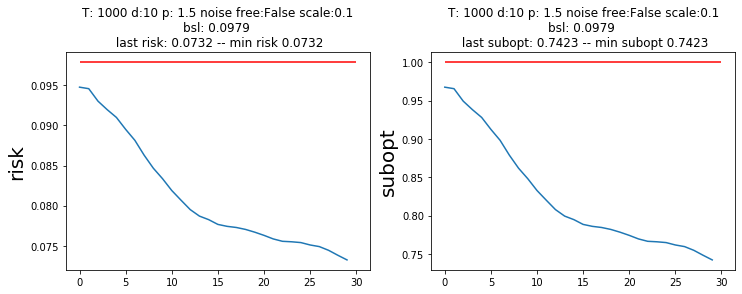

In [8]:
seed = 5
p = 1.5
T = 1000
d = 10
eta_scaling = 1e-1
test_flag = True
noise_free = False
p, d, T, algo, scale, noise_free, test_flag, params  = generate_params('NoisySFW', seed=seed, p=p, d=d, T=T, scale=eta_scaling,
                                                                      noise_free = noise_free, test_flag = test_flag)


f, axs = plt.subplots(1, 2, figsize=(12,4))
risk = [r[1] for r in params['result']['record']]
axs[0].plot(risk)
axs[0].set_title('T: {} d:{} p: {} noise free:{} scale:{}\nbsl: {:.4f} \n last risk: {:.4f} -- min risk {:.4f}'.format(
    T, d, p, noise_free, scale,
    params['result']['baseline'][0],
    params['result']['record'][-1][1],
    min(risk),
))
axs[0].hlines(params['result']['baseline'][0], 0, len(risk), 'r')
axs[0].set_ylabel('risk', fontsize=20)

subopt = [r[2] for r in params['result']['record']]
axs[1].plot(subopt)
axs[1].set_title('T: {} d:{} p: {} noise free:{} scale:{}\nbsl: {:.4f} \n last subopt: {:.4f} -- min subopt {:.4f}'.format(
    T, d, p, noise_free, scale,
    params['result']['baseline'][0],
    params['result']['record'][-1][2],
    min(subopt),
))
axs[1].hlines(1, 0, len(risk), 'r')
axs[1].set_ylabel('subopt', fontsize=20)

plt.show()